Boilerplate Connection Setup
---

In [2]:
%load_ext edx_jupyter

In [3]:
%%vertica

SELECT 'Connected'

,?column?
0,Connected


Set up parameters
---

In [4]:
less_recent_than = 7
more_recent_than = 28

Store queries
---

In [5]:
find_disengaged_users = """
SELECT
    act.user_id,
    act.course_id,
    act.last_activity_date,
    el.engagement_level
FROM
(
    SELECT
        act.user_id,
        act.course_id,
        act.last_activity_date
    FROM
    (
        SELECT
            user_id,
            course_id,
            MAX(date) AS last_activity_date
        FROM
            public.all_user_engagement
        WHERE
                is_engaged
            AND date <= :end_date
        GROUP BY 1, 2
    ) act
    JOIN
            experiment_courses as crs
        ON act.course_id = crs.course_id
    WHERE
        DATEDIFF('day', act.last_activity_date, :end_date) BETWEEN :less_recent_than AND :more_recent_than
) as act
JOIN
        production.d_user_course as uc
    ON uc.user_id = act.user_id
    AND uc.course_id = act.course_id
    AND (uc.first_verified_enrollment_time is NULL
         OR uc.first_verified_enrollment_time > :end_date)
LEFT JOIN
        first_week_engagement_level el
    ON el.user_id = act.user_id
    AND el.course_id = act.course_id
"""
    
latest_disengaged_course = """
SELECT DISTINCT
    user_id,
    LAST_VALUE(course_id) OVER (
        PARTITION BY user_id ORDER BY last_activity_date
        ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
    ) as course_id,
    LAST_VALUE(last_activity_date) OVER (
        PARTITION BY user_id ORDER BY last_activity_date
        ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
    ) as last_activity_date,
    LAST_VALUE(engagement_level) OVER (
        PARTITION BY user_id ORDER BY last_activity_date
        ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
    ) as engagement_level
"""

Fill in data for recent days
---

In [6]:
%%vertica
DROP TABLE IF EXISTS public.recent_user_engagement;
CREATE TABLE public.recent_user_engagement AS
SELECT
    user_id,
    course_id,
    date,
    CASE WHEN number_of_activities > 0 THEN 1 ELSE 0 END AS is_engaged
FROM
(
    SELECT
        context_user_id::INT AS user_id,
        context_course_id AS course_id,
        DATE(timestamp) AS date,
        CASE
            WHEN event_type = 'problem_check' THEN 'ATTEMPTED_PROBLEM'
            WHEN event_type = 'play_video' THEN 'PLAYED_VIDEO'
            ELSE 'POSTED_FORUM'
        END AS activity_type,
        COUNT(*) AS number_of_activities
    FROM
        experimental_events_run14.event_records
    WHERE
        project='tracking_prod'
        AND (
            (event_source='server' AND event_type='problem_check')
            OR (event_type LIKE 'edx.forum.%.created')
            OR (event_source IN ('browser', 'mobile') AND event_type='play_video')
        )
        AND DATE(timestamp) > (SELECT MAX(date) FROM production.f_user_activity)
        AND DATE(timestamp) < NOW()
    GROUP BY
        1, 2, 3, 4
) a;
GRANT SELECT ON public.recent_user_engagement TO standard;

,?column?


In [7]:
%%vertica
CREATE OR REPLACE VIEW public.all_user_engagement AS
SELECT
    user_id,
    course_id,
    date,
    is_engaged
FROM
    public.recent_user_engagement
UNION
SELECT
    user_id,
    course_id,
    date,
    is_engaged
FROM
    business_intelligence.activity_engagement_user_daily

,?column?


Find the most recent date of user activity imported
---

In [8]:
%%vertica -> latest_activity
SELECT MAX(date) FROM public.all_user_engagement

In [9]:
end_date = latest_activity['MAX'][0]

In [10]:
print(end_date.isoformat())

2017-06-05


Find the courses that meet our criteria
---

In [11]:
%%vertica (end_date=end_date)
DROP TABLE IF EXISTS experiment_courses;

CREATE TEMPORARY TABLE experiment_courses
ON COMMIT PRESERVE ROWS
AS SELECT
    course_id,
    course_start_date
FROM
    business_intelligence.course_master
WHERE
        (content_language is NULL OR content_language = 'en-us')
    AND pacing_type = 'self_paced'
    AND DATEDIFF('day', :end_date, course_verification_end_date) > 7
    AND :end_date < course_end_date
    AND DATEDIFF('day', course_start_date, :end_date) > 7

,MAX


In [12]:
%vertica SELECT COUNT(*) FROM experiment_courses

,COUNT
0,335


Identify highly engaged users
---

### Definitions

**Content Availability**: This is the first time the user is able to access the content within the course, it will either be the time they enroll or the start time of the course, whichever is greater.

#### Engagement Levels
* **high**: The user performed at least one engagement action in 2+ days in the first week of content availability
* **minimal**: The user performed at least one engagement action in exactly one day in the first week of content availability
* **never**: The user did not perform any engagement actions within the first week of content availability

In [13]:
%%vertica
DROP TABLE IF EXISTS user_content_availability;

CREATE TEMPORARY TABLE user_content_availability
ON COMMIT PRESERVE ROWS AS
SELECT
    CASE
        WHEN c.course_start_date >= uc.first_enrollment_time THEN c.course_start_date
        WHEN c.course_start_date < uc.first_enrollment_time THEN DATE(uc.first_enrollment_time)
    END AS content_availability_date,
    uc.user_id,
    uc.course_id
FROM
    production.d_user_course uc
JOIN
    business_intelligence.course_master c
ON
    uc.course_id = c.course_id
JOIN
    experiment_courses ec
ON
    ec.course_id = uc.course_id

,COUNT


In [14]:
%%vertica
DROP TABLE IF EXISTS first_week_engagement_level;

CREATE TEMPORARY TABLE first_week_engagement_level
ON COMMIT PRESERVE ROWS AS
SELECT
    e.user_id,
    e.course_id,
    ca.content_availability_date,
    CASE WHEN SUM(e.is_engaged) >= 2 THEN 'high'
         WHEN SUM(e.is_engaged) = 1 THEN 'minimal'
    END AS engagement_level
FROM
    business_intelligence.activity_engagement_user_daily e
JOIN
    user_content_availability ca
ON
    ca.course_id = e.course_id AND e.user_id = ca.user_id
WHERE
    DATEDIFF('day', ca.content_availability_date, e.date) BETWEEN 0 AND 6
GROUP BY 1, 2, 3
HAVING SUM(e.is_engaged) > 0

,COUNT


Find recently disengaged users
---

In [15]:
%%vertica (end_date=end_date, less_recent_than=less_recent_than, more_recent_than=more_recent_than)
DROP TABLE IF EXISTS recently_disengaged_users;

CREATE TEMPORARY TABLE recently_disengaged_users
ON COMMIT PRESERVE ROWS
AS {find_disengaged_users}

,COUNT


In [16]:
%vertica SELECT COUNT(*) FROM recently_disengaged_users

,COUNT
0,179867


In [17]:
%%vertica
DROP TABLE IF EXISTS most_recently_disengaged_user_course;

CREATE TEMPORARY TABLE most_recently_disengaged_user_course
ON COMMIT PRESERVE ROWS
AS {latest_disengaged_course} FROM recently_disengaged_users

,COUNT


In [18]:
%vertica SELECT COUNT(*) FROM most_recently_disengaged_user_course

,COUNT
0,149792


Count unique recently disengaged users in self-paced courses
---

In [19]:
%%vertica

SELECT
    COUNT(DISTINCT user_id)
FROM
    most_recently_disengaged_user_course

,COUNT
0,149792


Generate the list of user groups
---

In [20]:
%%vertica
CREATE TABLE ret.email_experiment AS
SELECT
    0 AS experiment_id,
    'Re-engagement email 2017-06-05' AS experiment_name,
    a.email,
    a.user_id,
    a.username,
    a.course_id,
    a.course_title,
    a.group_id,
    CASE
        WHEN a.group_id = 0 THEN 'Sent Email'
        WHEN a.group_id = 1 THEN 'Control'
    END AS group_name
FROM
(
    SELECT
        u.user_email AS email,
        uc.user_id,
        u.user_username AS username,
        uc.course_id,
        c.catalog_course_title AS course_title,
        RANDOMINT(2) AS group_id
    FROM
        most_recently_disengaged_user_course uc
    JOIN
        production.d_course c
        ON c.course_id = uc.course_id
    JOIN
        production.d_user u
        ON u.user_id = uc.user_id
) a

,COUNT


In [181]:
%%vertica -> experiment_users
SELECT
    uc.email,
    p.name,
    uc.course_id,
    uc.course_title,
    uc.group_id
FROM
    ret.email_experiment uc
JOIN
    lms_read_replica.auth_userprofile p ON
    p.user_id = uc.user_id

In [182]:
experiment_users.groupby('group_id').email.count()

group_id
0    74963
1    74829
Name: email, dtype: int64

In [183]:
experiment_users[experiment_users.group_id == 0][['email', 'name', 'course_id', 'course_title']].to_csv(
    're_engagement_experiment_treatment_group.csv', index=False)

See which organizations are most impacted
---

In [179]:
%%vertica
SELECT
    c.org_id,
    COUNT(*) AS cnt_users
FROM ret.email_experiment e
JOIN production.d_course c ON e.course_id = c.course_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 20

,org_id,cnt_users
0,Microsoft,42732
1,HarvardX,11039
2,LinuxFoundationX,6539
3,DelftX,5658
4,UBCx,5639
5,UQx,5168
6,TsinghuaX,3703
7,GalileoX,3631
8,MITx,3549
9,HKUSTx,3533


Count previously highly engaged, but now disengaged users in self-paced courses
---

In [24]:
%%vertica

SELECT
    engagement_level,
    COUNT(DISTINCT user_id)
FROM
    most_recently_disengaged_user_course
GROUP BY 1

,engagement_level,COUNT
0,minimal,74086
1,high,43783
2,None,31923


Count users disengaged from multiple courses
---

In [25]:
%%vertica

SELECT
    disengaged_count,
    COUNT(DISTINCT user_id)
FROM
(
    SELECT
        user_id,
        COUNT(DISTINCT course_id) as disengaged_count
    FROM
        recently_disengaged_users
    GROUP BY
        1
    HAVING
        COUNT(DISTINCT course_id) > 1
) as cnt
GROUP BY
    1
ORDER BY 1

,disengaged_count,COUNT
0,2,15736
1,3,3566
2,4,1110
3,5,366
4,6,178
5,7,97
6,8,41
7,9,16
8,10,15
9,11,5


Count unique recently disengaged users by amount of activity
---

In [26]:
%%vertica

SELECT
    act.activity_count,
    COUNT(DISTINCT act.user_id)
FROM
(
    SELECT
        act.user_id,
        act.course_id,
        count(*) as activity_count
    FROM
        production.f_user_activity as act
    JOIN
            most_recently_disengaged_user_course as rdu
        ON rdu.user_id = act.user_id
        AND rdu.course_id = act.course_id
    WHERE
            activity_type != 'ACTIVE'
        AND DATEDIFF('day', date, '{end_date}') BETWEEN {less_recent_than} AND {more_recent_than}
    GROUP BY 1, 2
) act
GROUP BY
    1
ORDER BY
    1

,activity_count,COUNT
0,1,65734
1,2,36974
2,3,13218
3,4,9944
4,5,5037
5,6,4224
6,7,2448
7,8,2034
8,9,1348
9,10,1014


VTR for English self-paced courses that started within the last year
---

In [27]:
%%vertica (end_date=end_date)

SELECT
    SUM(sum_verifications) / SUM(sum_enrolls_vtr)
FROM
    business_intelligence.course_stats_summary as stats
JOIN
        production.d_course as crs
    ON stats.course_id = crs.course_id
WHERE
        (crs.content_language is NULL OR crs.content_language = 'en-us')
    AND crs.pacing_type = 'self_paced'
    AND crs.start_time >= '2016-06-01'
    AND crs.start_time < :end_date

,?column?
0,0.020380891109723910


Count of unique recently disengaged users that have > 50% grade
---

In [28]:
%%vertica

SELECT
    (grd.percent_grade > 0.5),
    COUNT(DISTINCT rdu.user_id)
FROM
    most_recently_disengaged_user_course as rdu
LEFT JOIN
(
    SELECT
        course_id,
        user_id,
        MAX(percent_grade) as percent_grade
    FROM
        business_intelligence.grade_user_time
    GROUP BY
        1, 2
) as grd
    ON rdu.course_id = grd.course_id
   AND rdu.user_id = grd.user_id
GROUP BY
    1
ORDER BY
    1 DESC


,?column?,COUNT
0,None,42260
1,True,9867
2,False,97665


Count of recently disengaged users by country
---

In [29]:
%%vertica

SELECT
    usr.user_last_location_country_code,
    COUNT(DISTINCT rdu.user_id)
FROM
    most_recently_disengaged_user_course as rdu
JOIN
        production.d_user as usr
    ON rdu.user_id = usr.user_id
GROUP BY
    1
ORDER BY
    2 DESC

,user_last_location_country_code,COUNT
0,US,37004
1,IN,17422
2,UNKNOWN,7671
3,CA,6992
4,GB,5471
5,BR,4042
6,AU,3331
7,MX,3170
8,DE,3101
9,NL,2367


Find "recently disengaged" users from last month
---

In [144]:
import datetime

retrospective_end_date = datetime.date(2017, 5, 1)
window_end_date = datetime.date(2017, 6, 5)

In [145]:
%%vertica (end_date=retrospective_end_date)
DROP TABLE IF EXISTS experiment_courses;

CREATE TEMPORARY TABLE experiment_courses
ON COMMIT PRESERVE ROWS
AS SELECT
    course_id,
    course_start_date
FROM
    business_intelligence.course_master
WHERE
        (content_language is NULL OR content_language = 'en-us')
    AND pacing_type = 'self_paced'
    AND DATEDIFF('day', :end_date, course_verification_end_date) > 7
    AND :end_date < course_end_date
    AND DATEDIFF('day', course_start_date, :end_date) > 7

,verified_after,COUNT


In [116]:
%%vertica (end_date=retrospective_end_date, less_recent_than=less_recent_than, more_recent_than=more_recent_than)
DROP TABLE IF EXISTS baseline_recently_disengaged_users;

CREATE TEMPORARY TABLE baseline_recently_disengaged_users
ON COMMIT PRESERVE ROWS
AS {find_disengaged_users}

,verified_after,COUNT


In [117]:
%%vertica
DROP TABLE IF EXISTS baseline_most_recently_disengaged_user_course;

CREATE TEMPORARY TABLE baseline_most_recently_disengaged_user_course
ON COMMIT PRESERVE ROWS
AS {latest_disengaged_course} FROM baseline_recently_disengaged_users

,verified_after,COUNT


In [118]:
%%vertica

SELECT COUNT(DISTINCT user_id)
FROM
    baseline_most_recently_disengaged_user_course

,COUNT
0,154118


In [119]:
%%vertica
SELECT engagement_level, COUNT(*) FROM baseline_most_recently_disengaged_user_course GROUP BY 1

,engagement_level,COUNT
0,minimal,73579
1,high,38000
2,None,42539


Compute the return rate of recently disengaged users from last month
---

In [120]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter
import pandas as pd
import numpy as np
init_notebook_mode(connected=True)

In [121]:
%matplotlib inline

In [122]:
import matplotlib.pyplot as plt

In [146]:
%%vertica (retrospective_end_date=retrospective_end_date, window_end_date=window_end_date) -> return_rates
SELECT
    returned_after,
    engagement_level,
    COUNT(user_id)
FROM
(
    SELECT
        rdu.user_id,
        rdu.engagement_level,
        DATEDIFF('day', :retrospective_end_date, MIN(act.date)) as returned_after
    FROM
        baseline_most_recently_disengaged_user_course as rdu
    LEFT JOIN
            production.f_user_activity as act
         ON act.user_id = rdu.user_id
        AND act.course_id = rdu.course_id
        AND act.date BETWEEN :retrospective_end_date AND :window_end_date
        AND act.activity_type != 'ACTIVE'
    GROUP BY
        1, 2
) as return
GROUP BY
    1, 2
ORDER BY 1

In [147]:
return_rates_pivoted = pd.pivot_table(
    return_rates[return_rates.returned_after > 0].fillna('never'),
    values='COUNT',
    index='returned_after',
    columns='engagement_level',
    aggfunc=np.sum
)

In [148]:
return_rates_pivoted['total'] = return_rates_pivoted.high + return_rates_pivoted.minimal + return_rates_pivoted.never

In [149]:
return_rates_pivoted.head()

engagement_level,high,minimal,never,total
returned_after,,,,
1.0,784,692,650,2126
2.0,709,598,471,1778
3.0,518,469,360,1347
4.0,392,365,302,1059
5.0,345,295,289,929


In [150]:
%%vertica -> user_groups
SELECT
    COALESCE(engagement_level, 'never') AS engagement_level,
    COUNT(*) AS cnt_users
FROM
    baseline_most_recently_disengaged_user_course
GROUP BY 1
UNION
SELECT
    'total',
    (SELECT COUNT(*) FROM baseline_most_recently_disengaged_user_course) AS cnt_users

In [151]:
user_groups.set_index('engagement_level', inplace=True)

In [152]:
user_groups

,cnt_users
engagement_level,
high,38000
minimal,73579
total,154118
never,42539


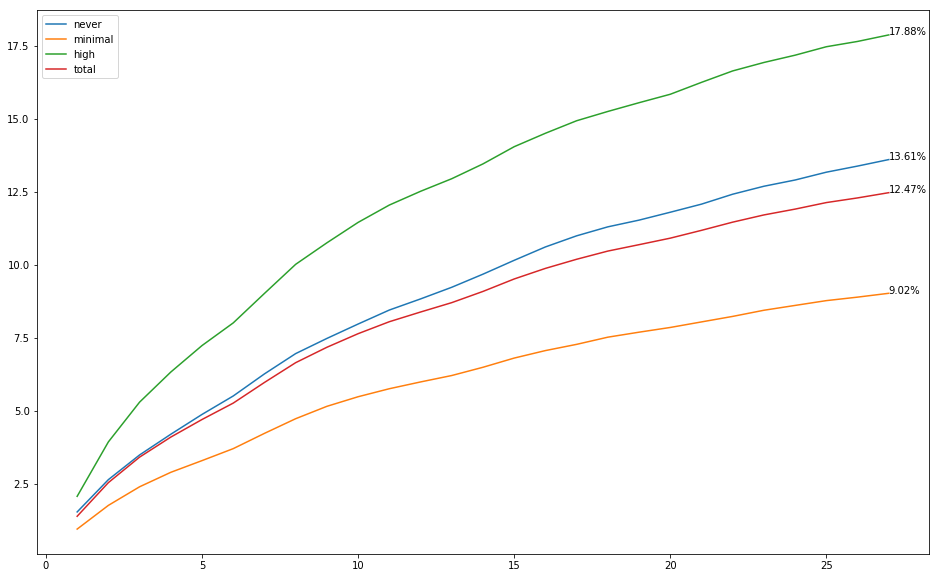

In [153]:
fig = plt.figure(figsize=(16, 10))
for col in ('never', 'minimal', 'high', 'total'):
    x = list(return_rates_pivoted.index)
    y = list(return_rates_pivoted[col].cumsum()/user_groups.loc[col][0]*100)
    plt.plot(x, y, label=col)
    plt.annotate(
        '{0}%'.format(round(y[-1], 2)),
        xy=(x[-1], y[-1])
    )
    plt.legend()

Compute the bookings rate of recently disengaged users from last month
---

In [154]:
%%vertica (retrospective_end_date=retrospective_end_date, window_end_date=window_end_date) -> verify_rates
SELECT
    verified_after,
    engagement_level,
    COUNT(user_id)
FROM
(
    SELECT
        rdu.user_id,
        rdu.engagement_level,
        DATEDIFF('day', :retrospective_end_date, MIN(crs.first_verified_enrollment_time)) as verified_after
    FROM
        baseline_most_recently_disengaged_user_course as rdu
    LEFT JOIN
            production.d_user_course as crs
        ON rdu.user_id = crs.user_id
        AND rdu.course_id = crs.course_id
        AND crs.first_verified_enrollment_time BETWEEN :retrospective_end_date AND :window_end_date
    GROUP BY
        1, 2
) as return
GROUP BY
    1, 2
ORDER BY 1

In [155]:
total_unverified_users = verify_rates['COUNT'].sum()

In [156]:
verify_rates_pivoted = pd.pivot_table(
    verify_rates[verify_rates.verified_after > 0].fillna('never'),
    values='COUNT',
    index='verified_after',
    columns='engagement_level',
    aggfunc=np.sum
)

In [157]:
verify_rates_pivoted['total'] = verify_rates_pivoted.high + verify_rates_pivoted.minimal + verify_rates_pivoted.never

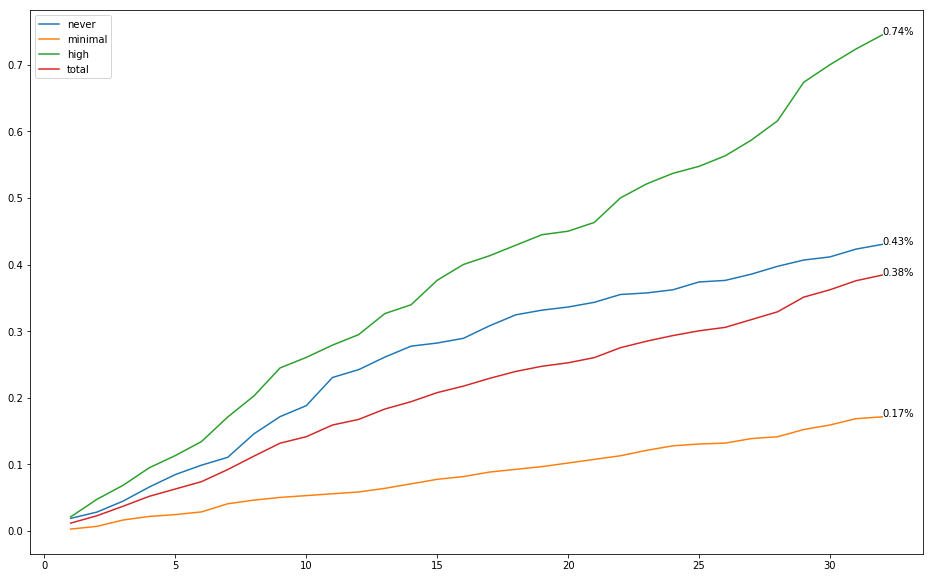

In [158]:
fig = plt.figure(figsize=(16, 10))
for col in ('never', 'minimal', 'high', 'total'):
    x = list(verify_rates_pivoted.index)
    y = list(verify_rates_pivoted[col].cumsum()/user_groups.loc[col][0]*100)
    plt.plot(x, y, label=col)
    plt.annotate(
        '{0}%'.format(round(y[-1], 2)),
        xy=(x[-1], y[-1])
    )
    plt.legend()

Find users who are minimally engaged in the first week from content availability, who we could potentially convert to highly engaged users
---

In [167]:
%%vertica (retrospective_end_date=retrospective_end_date, window_end_date=window_end_date)
DROP TABLE IF EXISTS most_recent_minimally_engaged_user;

CREATE TEMPORARY TABLE most_recent_minimally_engaged_user
ON COMMIT PRESERVE ROWS AS
SELECT
    a.user_id,
    a.course_id
FROM
(
    SELECT DISTINCT
        user_id,
        LAST_VALUE(course_id) OVER (PARTITION BY user_id ORDER BY content_availability_date ASC) AS course_id
    FROM
        first_week_engagement_level
    WHERE
        DATEDIFF('day', content_availability_date, :retrospective_end_date) BETWEEN 1 AND 6
        AND engagement_level='minimal'
) a
JOIN production.d_user_course du
ON
    du.user_id = a.user_id
    AND du.course_id = a.course_id
    AND (du.first_verified_enrollment_time IS NULL OR du.first_verified_enrollment_time BETWEEN :retrospective_end_date AND :window_end_date)

,verified_after,COUNT


In [168]:
%%vertica -> minimal_user_count
SELECT
    COUNT(user_id)
FROM
    most_recent_minimally_engaged_user

In [169]:
minimal_user_count = minimal_user_count.loc[0][0]

Run the return rate analysis for this set of users
---

In [170]:
%%vertica (retrospective_end_date=retrospective_end_date, window_end_date=window_end_date) -> return_rates
SELECT
    returned_after,
    COUNT(user_id)
FROM
(
    SELECT
        rdu.user_id,
        DATEDIFF('day', :retrospective_end_date, MIN(act.date)) as returned_after
    FROM
        most_recent_minimally_engaged_user as rdu
    LEFT JOIN
            production.f_user_activity as act
         ON act.user_id = rdu.user_id
        AND act.course_id = rdu.course_id
        AND act.date BETWEEN :retrospective_end_date AND :window_end_date
        AND act.activity_type != 'ACTIVE'
    GROUP BY
        1
) as return
GROUP BY
    1
ORDER BY 1

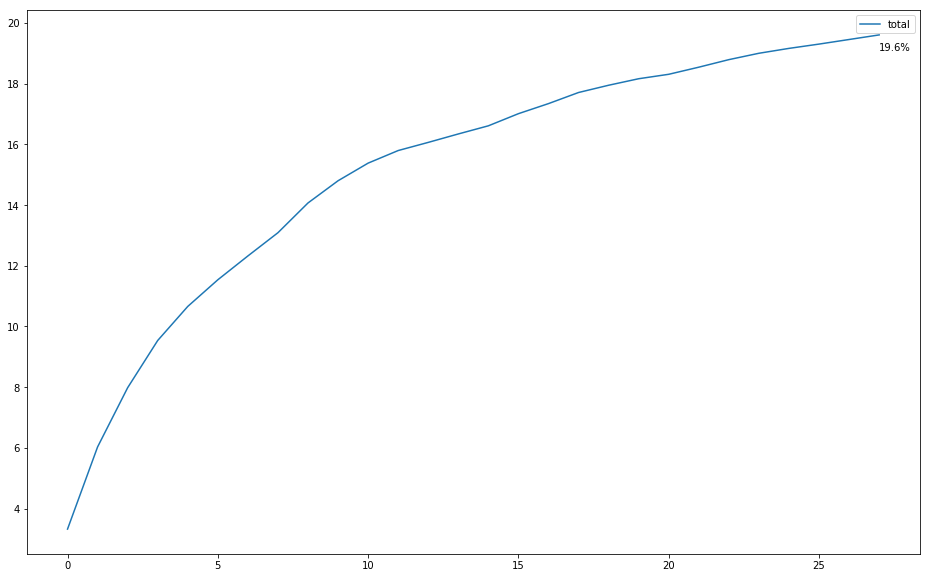

In [171]:
fig = plt.figure(figsize=(16, 10))
x = list(return_rates[1:].returned_after)
y = list(return_rates['COUNT'][1:].cumsum()/minimal_user_count*100)
plt.plot(x, y, label=col)
plt.annotate(
    '{0}%'.format(round(y[-1], 2)),
    xy=(x[-1], y[-1]-0.5)
)
plt.legend()

And verification rate...
---

In [172]:
%%vertica (retrospective_end_date=retrospective_end_date) -> verify_rates
SELECT
    verified_after,
    COUNT(user_id)
FROM
(
    SELECT
        rdu.user_id,
        DATEDIFF('day', :retrospective_end_date, MIN(crs.first_verified_enrollment_time)) as verified_after
    FROM
        most_recent_minimally_engaged_user as rdu
    LEFT JOIN
            production.d_user_course as crs
        ON rdu.user_id = crs.user_id
        AND rdu.course_id = crs.course_id
    GROUP BY
        1
) as v
GROUP BY
    1
ORDER BY 1

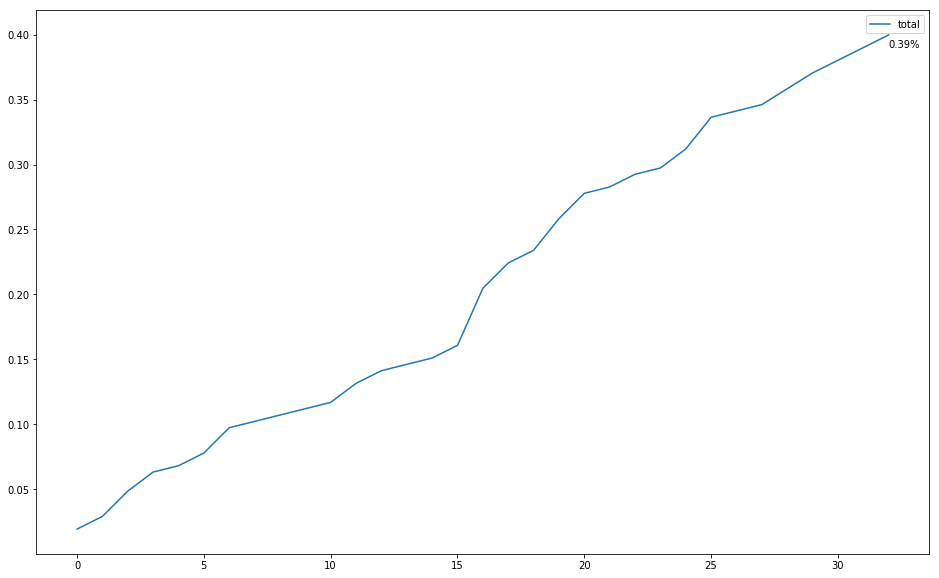

In [173]:
fig = plt.figure(figsize=(16, 10))
x = list(verify_rates[1:].verified_after)
y = list(verify_rates['COUNT'][1:].cumsum()/minimal_user_count*100)
plt.plot(x, y, label=col)
plt.annotate(
    '{0}%'.format(round(y[-2], 2)),
    xy=(x[-1], y[-2])
)
plt.legend()

In [174]:
minimal_user_count

20515